In [2]:
import tensorflow as tf
import pathlib
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

np.set_printoptions(precision=4)

2024-04-19 01:05:36.118951: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
tf.config.list_physical_devices()

2024-04-19 01:05:37.329001: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-04-19 01:05:37.329015: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:134] retrieving CUDA diagnostic information for host: 0b7292f20506
2024-04-19 01:05:37.329018: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:141] hostname: 0b7292f20506
2024-04-19 01:05:37.329063: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:165] libcuda reported version is: 545.29.6
2024-04-19 01:05:37.329073: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:169] kernel reported version is: 545.29.6
2024-04-19 01:05:37.329075: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:248] kernel version seems to match DSO: 545.29.6


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

## Preprocessing data

The [`Dataset.map(f)`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) transformation produces a new dataset by applying a given function `f` to each element of the input dataset. It is based on the [`map()`](https://en.wikipedia.org/wiki/Map_(higher-order_function)) function that is commonly applied to lists (and other structures) in functional programming languages. The function `f` takes the [`tf.Tensor`](https://www.tensorflow.org/api_docs/python/tf/Tensor) objects that represent a single element in the input, and returns the [`tf.Tensor`](https://www.tensorflow.org/api_docs/python/tf/Tensor) objects that will represent a single element in the new dataset. Its implementation uses standard TensorFlow operations to transform one element into another.

This section covers common examples of how to use [`Dataset.map()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map)

### Decoding image data and resizing it

When training a neural network on real-world image data, it is often necessary to convert images of different sizes to a common size, so that they may be batched into a fixed size.

Rebuild the flower filenames dataset:

In [4]:
flowers = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)

In [5]:
flowers_root = pathlib.Path(flowers)

In [6]:
list_ds = tf.data.Dataset.list_files(str(flowers_root/'*/*'))

Write a function that manipulates the dataset elements.

In [7]:
# Reads an image from a file, decodes it into a dense tensor, and resizes it
# to a fixed shape.
def parse_image(filename):
  parts = tf.strings.split(filename, os.sep)
  label = parts[-2]

  image = tf.io.read_file(filename)
  image = tf.io.decode_jpeg(image)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, [128, 128])
  return image, label

Test that it works.

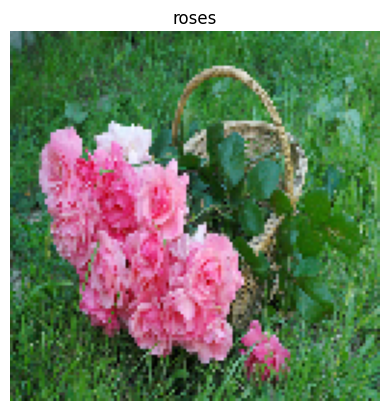

In [8]:
file_path = next(iter(list_ds))
image, label = parse_image(file_path)

def show(image, label):
  plt.figure()
  plt.imshow(image)
  plt.title(label.numpy().decode('utf-8'))
  plt.axis('off')

show(image, label)

Map it over the dataset

2024-04-19 01:05:37.582146: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


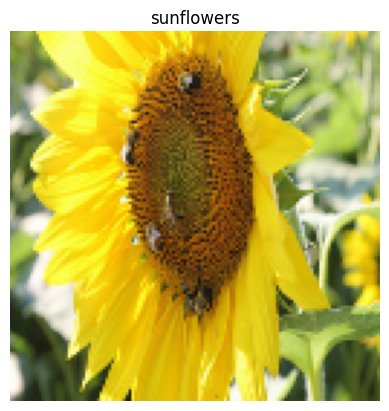

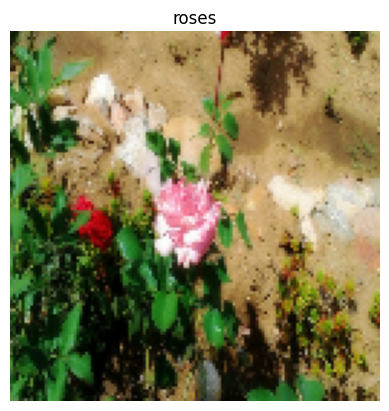

In [9]:
images_ds = list_ds.map(parse_image)

for image, label in images_ds.take(2):
  show(image, label)

In [10]:
images_ds

<_MapDataset element_spec=(TensorSpec(shape=(128, 128, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>

In [48]:
images_ds_take = images_ds.take(2)
images_ds_take

<_TakeDataset element_spec=(TensorSpec(shape=(128, 128, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>

In [46]:
b_images_ds = images_ds.batch(2)
b_images_ds

<_BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>

In [47]:
b_images_ds_take = b_images_ds.take(1)
b_images_ds_take

<_TakeDataset element_spec=(TensorSpec(shape=(None, 128, 128, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>

In [54]:
for batch in b_images_ds:
    print(batch[1])  # batch is a tuple
    print(batch[0][0].shape)
    break

tf.Tensor([b'dandelion' b'tulips'], shape=(2,), dtype=string)
(128, 128, 3)


### Applying arbitrary Python logic

For performance reasons, use TensorFlow operations for preprocessing your data whenever possible. However, it is sometimes useful to call external Python libraries when parsing your input data. You can use the [`tf.py_function`](https://www.tensorflow.org/api_docs/python/tf/py_function) operation in a [`Dataset.map`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) transformation.

For example, if you want to apply a random rotation, the [`tf.image`](https://www.tensorflow.org/api_docs/python/tf/image) module only has [`tf.image.rot90`](https://www.tensorflow.org/api_docs/python/tf/image/rot90), which is not very useful for image augmentation.

**Note:** `tensorflow_addons` has a TensorFlow compatible `rotate` in `tensorflow_addons.image.rotate`.

To demonstrate [`tf.py_function`](https://www.tensorflow.org/api_docs/python/tf/py_function), try using the `scipy.ndimage.rotate` function instead:

In [11]:
import scipy.ndimage as ndimage

@tf.py_function(Tout=tf.float32)
def random_rotate_image(image):
  image = ndimage.rotate(image, np.random.uniform(-30, 30), reshape=False)
  return image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


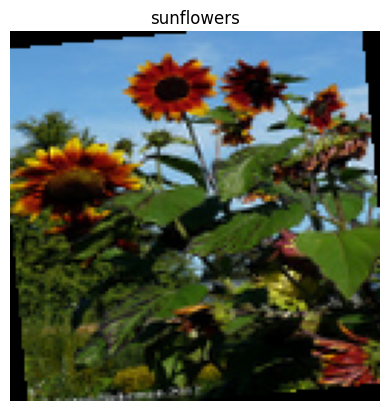

In [12]:
image, label = next(iter(images_ds))
image = random_rotate_image(image)
show(image, label)

To use this function with [`Dataset.map`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) the same caveats apply as with [`Dataset.from_generator`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_generator), you need to describe the return shapes and types when you apply the function:

In [13]:
def tf_random_rotate_image(image, label):
  im_shape = image.shape
  image = random_rotate_image(image)
  image.set_shape(im_shape)
  return image, label

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2024-04-19 01:05:37.980925: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


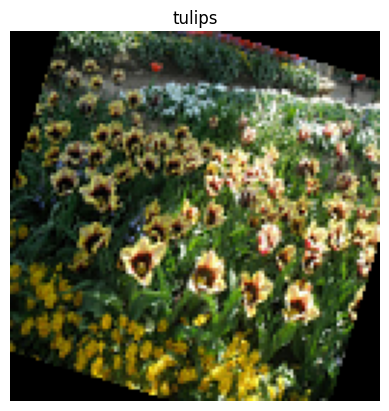

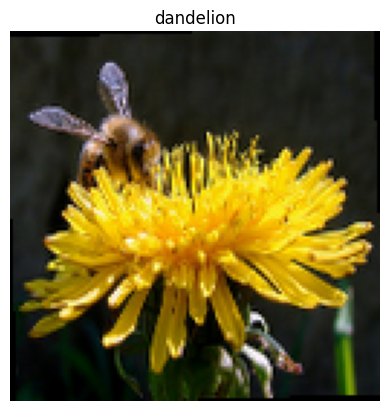

In [14]:
rot_ds = images_ds.map(tf_random_rotate_image)

for image, label in rot_ds.take(2):
  show(image, label)

### Parsing `tf.Example` protocol buffer messages

Many input pipelines extract [`tf.train.Example`](https://www.tensorflow.org/api_docs/python/tf/train/Example) protocol buffer messages from a TFRecord format. Each [`tf.train.Example`](https://www.tensorflow.org/api_docs/python/tf/train/Example) record contains one or more "features", and the input pipeline typically converts these features into tensors.

In [15]:
fsns_test_file = tf.keras.utils.get_file("fsns.tfrec", "https://storage.googleapis.com/download.tensorflow.org/data/fsns-20160927/testdata/fsns-00000-of-00001")
dataset = tf.data.TFRecordDataset(filenames = [fsns_test_file])
dataset

<TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

You can work with [`tf.train.Example`](https://www.tensorflow.org/api_docs/python/tf/train/Example) protos outside of a [`tf.data.Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) to understand the data:

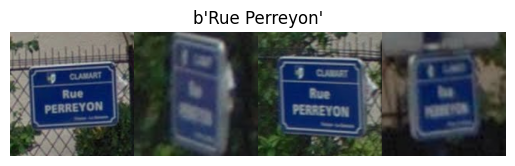

In [16]:
raw_example = next(iter(dataset))
parsed = tf.train.Example.FromString(raw_example.numpy())

feature = parsed.features.feature
raw_img = feature['image/encoded'].bytes_list.value[0]
img = tf.image.decode_png(raw_img)
plt.imshow(img)
plt.axis('off')
_ = plt.title(feature["image/text"].bytes_list.value[0])

In [17]:
raw_example = next(iter(dataset))

In [18]:
def tf_parse(eg):
  example = tf.io.parse_example(
      eg[tf.newaxis], {
          'image/encoded': tf.io.FixedLenFeature(shape=(), dtype=tf.string),
          'image/text': tf.io.FixedLenFeature(shape=(), dtype=tf.string)
      })
  return example['image/encoded'][0], example['image/text'][0]

In [19]:
img, txt = tf_parse(raw_example)
print(txt.numpy())
print(repr(img.numpy()[:20]), "...")

b'Rue Perreyon'
b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02X' ...


In [20]:
decoded = dataset.map(tf_parse)
decoded

<_MapDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>

In [21]:
image_batch, text_batch = next(iter(decoded.batch(10)))
image_batch.shape

TensorShape([10])

### Time series windowing

For an end-to-end time series example see: [Time series forecasting](https://www.tensorflow.org/tutorials/structured_data/time_series).

Time series data is often organized with the time axis intact.

Use a simple [`Dataset.range`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#range) to demonstrate:

In [22]:
range_ds = tf.data.Dataset.range(100000)

Typically, models based on this sort of data will want a contiguous time slice.

The simplest approach would be to batch the data:

#### Using `batch`

In [23]:
batches = range_ds.batch(10, drop_remainder=True)

for batch in batches.take(5):
  print(batch.numpy())

[0 1 2 3 4 5 6 7 8 9]
[10 11 12 13 14 15 16 17 18 19]
[20 21 22 23 24 25 26 27 28 29]
[30 31 32 33 34 35 36 37 38 39]
[40 41 42 43 44 45 46 47 48 49]


2024-04-19 01:05:38.284146: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Or to make dense predictions one step into the future, you might shift the features and labels by one step relative to each other:

In [24]:
def dense_1_step(batch):
  # Shift features and labels one step relative to each other.
  return batch[:-1], batch[1:]

predict_dense_1_step = batches.map(dense_1_step)

for features, label in predict_dense_1_step.take(3):
  print(features.numpy(), " => ", label.numpy())

[0 1 2 3 4 5 6 7 8]  =>  [1 2 3 4 5 6 7 8 9]
[10 11 12 13 14 15 16 17 18]  =>  [11 12 13 14 15 16 17 18 19]
[20 21 22 23 24 25 26 27 28]  =>  [21 22 23 24 25 26 27 28 29]


2024-04-19 01:05:38.309597: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


To predict a whole window instead of a fixed offset you can split the batches into two parts:

In [25]:
batches = range_ds.batch(15, drop_remainder=True)

def label_next_5_steps(batch):
  return (batch[:-5],   # Inputs: All except the last 5 steps
          batch[-5:])   # Labels: The last 5 steps

predict_5_steps = batches.map(label_next_5_steps)

for features, label in predict_5_steps.take(3):
  print(features.numpy(), " => ", label.numpy())

[0 1 2 3 4 5 6 7 8 9]  =>  [10 11 12 13 14]
[15 16 17 18 19 20 21 22 23 24]  =>  [25 26 27 28 29]
[30 31 32 33 34 35 36 37 38 39]  =>  [40 41 42 43 44]


2024-04-19 01:05:38.334832: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


#### To allow some overlap between the features of one batch and the labels of another, use [`Dataset.zip`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#zip):

In [26]:
feature_length = 10
label_length = 3

features = range_ds.batch(feature_length, drop_remainder=True)
labels = range_ds.batch(feature_length).skip(1).map(lambda labels: labels[:label_length])

predicted_steps = tf.data.Dataset.zip((features, labels))

for features, label in predicted_steps.take(5):
  print(features.numpy(), " => ", label.numpy())

[0 1 2 3 4 5 6 7 8 9]  =>  [10 11 12]
[10 11 12 13 14 15 16 17 18 19]  =>  [20 21 22]
[20 21 22 23 24 25 26 27 28 29]  =>  [30 31 32]
[30 31 32 33 34 35 36 37 38 39]  =>  [40 41 42]
[40 41 42 43 44 45 46 47 48 49]  =>  [50 51 52]


2024-04-19 01:05:38.356469: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


#### Using `window`

While using [`Dataset.batch`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch) works, there are situations where you may need finer control. The [`Dataset.window`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#window) method gives you complete control, but requires some care: it returns a `Dataset` of `Datasets`. Go to the [Dataset structure](https://www.tensorflow.org/guide/data#dataset_structure) section for details.

In [27]:
window_size = 5

windows = range_ds.window(window_size, shift=1)
for sub_ds in windows.take(5):
  print(sub_ds)

<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>


2024-04-19 01:05:38.364762: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


The [`Dataset.flat_map`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#flat_map) method can take a dataset of datasets and flatten it into a single dataset:

In [28]:
for x in windows.flat_map(lambda x: x).take(30):
   print(x.numpy(), end=' ')

0 1 2 3 4 1 2 3 4 5 2 3 4 5 6 3 4 5 6 7 4 5 6 7 8 5 6 7 8 9 

2024-04-19 01:05:38.380257: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


n nearly all cases, you will want to [`Dataset.batch`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch) the dataset first:

In [29]:
def sub_to_batch(sub):
  return sub.batch(window_size, drop_remainder=True)

for example in windows.flat_map(sub_to_batch).take(5):
  print(example.numpy())

[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]


2024-04-19 01:05:38.404246: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Now, you can see that the `shift` argument controls how much each window moves over.

Putting this together you might write this function:

In [30]:
def make_window_dataset(ds, window_size=5, shift=1, stride=1):
  windows = ds.window(window_size, shift=shift, stride=stride)

  def sub_to_batch(sub):
    return sub.batch(window_size, drop_remainder=True)

  windows = windows.flat_map(sub_to_batch)
  return windows

In [31]:
ds = make_window_dataset(range_ds, window_size=10, shift=5, stride=3)

for example in ds.take(10):
  print(example.numpy())

[ 0  3  6  9 12 15 18 21 24 27]
[ 5  8 11 14 17 20 23 26 29 32]
[10 13 16 19 22 25 28 31 34 37]
[15 18 21 24 27 30 33 36 39 42]
[20 23 26 29 32 35 38 41 44 47]
[25 28 31 34 37 40 43 46 49 52]
[30 33 36 39 42 45 48 51 54 57]
[35 38 41 44 47 50 53 56 59 62]
[40 43 46 49 52 55 58 61 64 67]
[45 48 51 54 57 60 63 66 69 72]


2024-04-19 01:05:38.430648: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Then it's easy to extract labels, as before:

In [32]:
dense_labels_ds = ds.map(dense_1_step)

for inputs,labels in dense_labels_ds.take(3):
  print(inputs.numpy(), "=>", labels.numpy())

[ 0  3  6  9 12 15 18 21 24] => [ 3  6  9 12 15 18 21 24 27]
[ 5  8 11 14 17 20 23 26 29] => [ 8 11 14 17 20 23 26 29 32]
[10 13 16 19 22 25 28 31 34] => [13 16 19 22 25 28 31 34 37]


2024-04-19 01:05:38.449604: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Resampling

When working with a dataset that is very class-imbalanced, you may want to resample the dataset. [`tf.data`](https://www.tensorflow.org/api_docs/python/tf/data) provides two methods to do this. The credit card fraud dataset is a good example of this sort of problem.


**Note:** Go to [Classification on imbalanced data](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data) for a full tutorial.

In [33]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/download.tensorflow.org/data/creditcard.zip',
    fname='creditcard.zip',
    extract=True)

csv_path = zip_path.replace('.zip', '.csv')

In [34]:
creditcard_ds = tf.data.experimental.make_csv_dataset(
    csv_path, batch_size=1024, label_name="Class",
    # Set the column types: 30 floats and an int.
    column_defaults=[float()]*30+[int()])

Now, check the distribution of classes, it is highly skewed:

In [35]:
def count(counts, batch):
  features, labels = batch
  class_1 = labels == 1
  class_1 = tf.cast(class_1, tf.int32)

  class_0 = labels == 0
  class_0 = tf.cast(class_0, tf.int32)

  counts['class_0'] += tf.reduce_sum(class_0)
  counts['class_1'] += tf.reduce_sum(class_1)

  return counts

In [36]:
counts = creditcard_ds.take(10).reduce(
    initial_state={'class_0': 0, 'class_1': 0},
    reduce_func = count)

counts = np.array([counts['class_0'].numpy(),
                   counts['class_1'].numpy()]).astype(np.float32)

fractions = counts/counts.sum()
print(fractions)

[0.9953 0.0047]


#### Datasets sampling

One approach to resampling a dataset is to use `sample_from_datasets`. This is more applicable when you have a separate [`tf.data.Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) for each class.

Here, just use filter to generate them from the credit card fraud data:

In [37]:
negative_ds = (
  creditcard_ds
    .unbatch()
    .filter(lambda features, label: label==0)
    .repeat())
positive_ds = (
  creditcard_ds
    .unbatch()
    .filter(lambda features, label: label==1)
    .repeat())

In [38]:
for features, label in positive_ds.batch(10).take(1):
  print(label.numpy())

[1 1 1 1 1 1 1 1 1 1]


2024-04-19 01:05:40.066451: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


To use [`tf.data.Dataset.sample_from_datasets`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#sample_from_datasets) pass the datasets, and the weight for each:

In [39]:
balanced_ds = tf.data.Dataset.sample_from_datasets(
    [negative_ds, positive_ds], [0.5, 0.5]).batch(10)

Now the dataset produces examples of each class with a 50/50 probability:

In [40]:
for features, labels in balanced_ds.take(10):
  print(labels.numpy())

[1 1 1 0 0 0 1 0 1 0]
[0 1 0 0 1 0 0 0 0 1]
[0 1 0 0 0 0 0 1 0 0]
[1 1 0 1 0 1 1 0 0 1]
[1 1 0 1 0 0 1 1 0 0]
[0 1 1 0 0 0 1 1 0 0]
[0 1 0 1 0 0 1 0 1 1]
[1 1 0 1 0 0 1 1 1 0]
[0 0 1 1 0 1 1 0 0 0]
[1 0 0 1 0 1 1 0 0 1]


2024-04-19 01:05:40.798660: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Rejection resampling
One problem with the above Dataset.sample_from_datasets approach is that it needs a separate tf.data.Dataset per class. You could use Dataset.filter to create those two datasets, but that results in all the data being loaded twice.

The tf.data.Dataset.rejection_resample method can be applied to a dataset to rebalance it, while only loading it once. Elements will be dropped or repeated to achieve balance.

The rejection_resample method takes a class_func argument. This class_func is applied to each dataset element, and is used to determine which class an example belongs to for the purposes of balancing.

The goal here is to balance the label distribution, and the elements of creditcard_ds are already (features, label) pairs. So the class_func just needs to return those labels

#### Rejection resampling

One problem with the above [`Dataset.sample_from_datasets`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#sample_from_datasets) approach is that it needs a separate [`tf.data.Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) per class. You could use [`Dataset.filter`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#filter) to create those two datasets, but that results in all the data being loaded twice.

The [`tf.data.Dataset.rejection_resample`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#rejection_resample) method can be applied to a dataset to rebalance it, while only loading it once. Elements will be dropped or repeated to achieve balance.

The `rejection_resample` method takes a `class_func` argument. This `class_func` is applied to each dataset element, and is used to determine which class an example belongs to for the purposes of balancing.

The goal here is to balance the label distribution, and the elements of `creditcard_ds` are already `(features, label)` pairs. So the `class_func` just needs to return those labels

In [41]:
def class_func(features, label):
  return label

The resampling method deals with individual examples, so in this case you must unbatch the dataset before applying that method.

The method needs a target distribution, and optionally an initial distribution estimate as inputs.

In [42]:
resample_ds = (
    creditcard_ds
    .unbatch()
    .rejection_resample(class_func, target_dist=[0.5,0.5],
                        initial_dist=fractions)
    .batch(10))

Instructions for updating:
Use tf.print instead of tf.Print. Note that tf.print returns a no-output operator that directly prints the output. Outside of defuns or eager mode, this operator will not be executed unless it is directly specified in session.run or used as a control dependency for other operators. This is only a concern in graph mode. Below is an example of how to ensure tf.print executes in graph mode:



The `rejection_resample` method returns `(class, example)` pairs where the `class` is the output of the `class_func`. In this case, the `example` was already a `(feature, label)` pair, so use `map` to drop the extra copy of the labels:

In [43]:
balanced_ds = resample_ds.map(lambda extra_label, features_and_label: features_and_label)

In [44]:
for features, labels in balanced_ds.take(10):
  print(labels.numpy())

Proportion of examples rejected by sampler is high: [0.995312512][0.995312512 0.0046875][0 1]
Proportion of examples rejected by sampler is high: [0.995312512][0.995312512 0.0046875][0 1]
Proportion of examples rejected by sampler is high: [0.995312512][0.995312512 0.0046875][0 1]
Proportion of examples rejected by sampler is high: [0.995312512][0.995312512 0.0046875][0 1]
Proportion of examples rejected by sampler is high: [0.995312512][0.995312512 0.0046875][0 1]
Proportion of examples rejected by sampler is high: [0.995312512][0.995312512 0.0046875][0 1]
Proportion of examples rejected by sampler is high: [0.995312512][0.995312512 0.0046875][0 1]
Proportion of examples rejected by sampler is high: [0.995312512][0.995312512 0.0046875][0 1]
Proportion of examples rejected by sampler is high: [0.995312512][0.995312512 0.0046875][0 1]
Proportion of examples rejected by sampler is high: [0.995312512][0.995312512 0.0046875][0 1]


[1 0 1 0 1 1 0 0 1 0]
[1 1 1 0 0 0 1 1 0 0]
[1 1 0 1 0 0 0 1 0 1]
[0 1 0 0 1 0 1 0 1 0]
[0 0 0 1 0 0 1 0 0 1]
[1 0 0 1 1 0 1 0 1 1]
[0 1 0 0 1 0 1 1 0 1]
[1 0 0 1 1 1 0 1 0 1]
[1 0 0 1 1 1 0 1 1 1]
[0 1 0 0 0 1 0 0 0 1]


2024-04-19 01:05:41.730091: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Iterator Checkpointing

Tensorflow supports [taking checkpoints](https://www.tensorflow.org/guide/checkpoint) so that when your training process restarts it can restore the latest checkpoint to recover most of its progress. In addition to checkpointing the model variables, you can also checkpoint the progress of the dataset iterator. This could be useful if you have a large dataset and don't want to start the dataset from the beginning on each restart. Note however that iterator checkpoints may be large, since transformations such as [`Dataset.shuffle`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle) and [`Dataset.prefetch`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) require buffering elements within the iterator.

To include your iterator in a checkpoint, pass the iterator to the [`tf.train.Checkpoint`](https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint) constructor.

In [45]:
range_ds = tf.data.Dataset.range(20)

iterator = iter(range_ds)
ckpt = tf.train.Checkpoint(step=tf.Variable(0), iterator=iterator)
manager = tf.train.CheckpointManager(ckpt, '/tmp/my_ckpt', max_to_keep=3)

print([next(iterator).numpy() for _ in range(5)])

save_path = manager.save()

print([next(iterator).numpy() for _ in range(5)])

ckpt.restore(manager.latest_checkpoint)

print([next(iterator).numpy() for _ in range(5)])

[0, 1, 2, 3, 4]
[5, 6, 7, 8, 9]
[5, 6, 7, 8, 9]
